# Info about dataset

In [2]:
from torch_geometric.datasets import KarateClub
# Load the KarateClub dataset
dataset = KarateClub()
print(f"number of graphs:{len(dataset)}")
print(f"number of features:{dataset.num_features}")
print(f"number of classes:{dataset.num_classes}")
print(60 * "*")

data=dataset[0]
print(data)
print(data.train_mask)
# print(data.val_mask)
# print(data.test_mask)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f"number of  training nodes:{data.train_mask.sum()}")
# print(f"number of  test nodes:{data.test_mask.sum()}")
print(f"Training node label rate:{int(data.train_mask.sum()) / data.num_nodes : .3f}")
print(f"Is Undirected:{data.is_undirected()}")


number of graphs:1
number of features:34
number of classes:4
************************************************************
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])
Number of nodes: 34
Number of edges: 156
number of  training nodes:4
Training node label rate: 0.118
Is Undirected:True


In [3]:
print(len(data.edge_index))
print(len(data.edge_index.t()))
data.edge_index.t() # t() for transpose

2
156


tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

# Show the KarateClub dataset

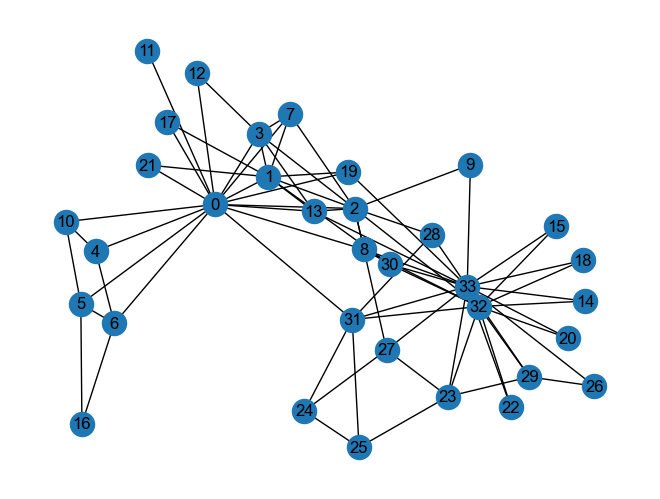

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
# Convert the data to a NetworkX graph object
edge_index = data.edge_index.numpy()
graph = nx.from_edgelist(edge_index.transpose())

# Visualize the graph using NetworkX
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True)
plt.show()

In [5]:
import torch
from sklearn.model_selection import train_test_split

# Split the data : 70% train & 30% test no validation
train_idx, test_idx = train_test_split(range(data.num_nodes), test_size=0.3)
print(train_idx)
print(test_idx)
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
print(data.train_mask)
data.train_mask[train_idx] = True
print(data.train_mask)
data.test_mask[test_idx] = True

print('Number of nodes in train set:', data.train_mask.sum().item())
print('Number of nodes in test set:', data.test_mask.sum().item())

[6, 2, 3, 33, 8, 13, 20, 16, 4, 28, 17, 0, 25, 15, 32, 5, 10, 31, 30, 12, 7, 1, 29]
[26, 24, 19, 14, 22, 27, 18, 9, 21, 11, 23]
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False])
tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True, False,  True,  True, False,  True,  True,  True, False, False,
         True, False, False, False, False,  True, False, False,  True,  True,
         True,  True,  True,  True])
Number of nodes in train set: 23
Number of nodes in test set: 11


In [6]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv #GATConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(1)

        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels,20)
        self.out = Linear(20, dataset.num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training) #Dropout is only applied in the training step, but not for predictions

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer
        x = F.softmax(self.out(x), dim=1)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(34, 16)
  (conv2): GCNConv(16, 20)
  (out): Linear(in_features=20, out_features=4, bias=True)
)


In [7]:
# Initialize model
model = GCN(hidden_channels=16)

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=decay)
# Define loss function (CrossEntropyLoss for Classification Problems with
# probability distributions)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      # Use all data as input, because all nodes have node features
      out = model(data.x, data.edge_index)
      # Only use nodes with labels available for loss calculation --> mask
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      # Use the class with highest probability.
      pred = out.argmax(dim=1)
      # Check against ground-truth labels.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      # Derive ratio of correct predictions.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc

losses = []
n_epoch=100
for epoch in range(n_epoch):
    loss = train()
    losses.append(loss)
    # if epoch % 100 == 0:
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 1.3870
Epoch: 001, Loss: 1.3834
Epoch: 002, Loss: 1.3829
Epoch: 003, Loss: 1.3796
Epoch: 004, Loss: 1.3790
Epoch: 005, Loss: 1.3765
Epoch: 006, Loss: 1.3730
Epoch: 007, Loss: 1.3725
Epoch: 008, Loss: 1.3692
Epoch: 009, Loss: 1.3700
Epoch: 010, Loss: 1.3677
Epoch: 011, Loss: 1.3595
Epoch: 012, Loss: 1.3571
Epoch: 013, Loss: 1.3463
Epoch: 014, Loss: 1.3398
Epoch: 015, Loss: 1.3382
Epoch: 016, Loss: 1.3354
Epoch: 017, Loss: 1.3312
Epoch: 018, Loss: 1.3194
Epoch: 019, Loss: 1.2995
Epoch: 020, Loss: 1.3117
Epoch: 021, Loss: 1.3075
Epoch: 022, Loss: 1.2293
Epoch: 023, Loss: 1.2532
Epoch: 024, Loss: 1.2262
Epoch: 025, Loss: 1.2461
Epoch: 026, Loss: 1.2412
Epoch: 027, Loss: 1.2115
Epoch: 028, Loss: 1.1763
Epoch: 029, Loss: 1.1893
Epoch: 030, Loss: 1.1817
Epoch: 031, Loss: 1.1347
Epoch: 032, Loss: 1.1389
Epoch: 033, Loss: 1.1078
Epoch: 034, Loss: 1.1164
Epoch: 035, Loss: 1.0606
Epoch: 036, Loss: 1.1517
Epoch: 037, Loss: 1.0496
Epoch: 038, Loss: 1.0043
Epoch: 039, Loss: 1.0307


In [8]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8182
